### How to push to github
##### Write the following in the git terminal:
##### git add *
##### git commit -m "Write the changes in the file that were done here"
##### git push

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn
from scipy.integrate import quad
import csv
from scipy import optimize
from scipy import integrate
from scipy.integrate import odeint
import pandas as pd

C:\Users\press\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%run CrossSectionFunctions.ipynb

# Particle properties
particle_mass = {
    'Proton': 120,
    'Lambda': 200,
    'Neutron': 100,
    'NeutralPion': 50,
    'ChargedPion': 60,
    'NeutralKaon': 80,
    'ChargedKaon': 90
}


particle_coupling_constants = {
    'NeutralPion': 5e-1
}

particle_ratios = {
    particle: particle_mass[particle] / particle_mass["Lambda"]
    for particle in particle_mass
}

linestyles = {
    "Proton": "-", 
    "Neutron": "--", 
    "Lambda": "-.", 
    "ChargedPion": ":", 
    "NeutralPion": (0, (3, 1, 1, 1)),  # Custom dash pattern
    "ChargedKaon": (0, (5, 2)), 
    "NeutralKaon": (0, (1, 1))
}

decay_products = {
    "Lambda": [("Neutron", "NeutralPion"), ("Proton", "ChargedPion")],
    "NeutralKaon": [("NeutralPion", "NeutralPion"), ("ChargedPion", "ChargedPion")],
    "ChargedKaon": [("ChargedPion", "NeutralPion"), 
                    ("ChargedPion", "ChargedPion", "NeutralPion"),
                    ("NeutralPion", "NeutralPion")]
}

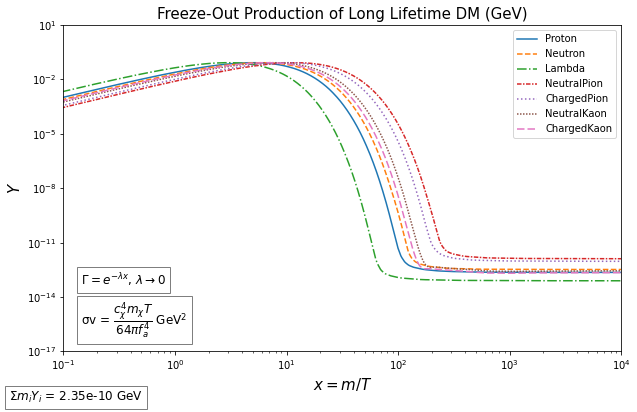

In [3]:
# Integration setup
particles = ["Proton", "Neutron", "Lambda", "NeutralPion", "ChargedPion", "NeutralKaon", "ChargedKaon"]

x_min, x_max = 1e-2, 1E4
x_eval = np.logspace(np.log10(x_min), np.log10(x_max), 10000)

# Plot equilibrium abundance
xx = np.logspace(np.log10(x_min), np.log10(1000), 10000)
#plt.loglog(xx, Y_EQ(xx, 'Proton'), 'c', label=r'$Y_{\rm eq}$, Proton')
plt.figure(figsize=(10, 6))


FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particles:
    mass = particle_mass.get(particle, 1)
    
    sol = integrate.solve_ivp(
        lambda x, logY: dYdx_logdynamic(x, logY, particle),
        (x_min, x_max),
        [np.log(np.array(Y_EQ(x_min, particle)))],  
        method='BDF',  
        t_eval=x_eval,
        rtol=1e-2,
        atol=1e-2,
        jac = None
    )

    # Convert back from log space
    Y_values = np.exp(sol.y[0])

    plt.loglog(sol.t, Y_values, label=f'{particle}',linestyle=linestyles.get(particle, "-"))

    FreezeOutNumber = np.append(FreezeOutNumber, Y_values[-1])
    masses = np.append(masses, mass)

#print('masses = ', masses)
#print('fz', FreezeOutNumber)
#print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')


plt.gcf().text(0.15, 0.15, r"σv = $\dfrac{c_{χ}^{4} m_χT}{64πf_a^4} $ GeV$^{2}$", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
plt.gcf().text(0.15, 0.27, r"$\Gamma = e^{-\lambda x}$, $\lambda \rightarrow 0$", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
plt.gcf().text(0.05, 0.001, rf"$\Sigma m_{{i}}Y_{{i}}$ = {format(np.sum(np.multiply(masses, FreezeOutNumber)), '.2e')} GeV", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))

plt.ylim(1E-17,10)
plt.xlim(0.1,x_max)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-Out Production of Long Lifetime DM (GeV)', size= 15)
plt.legend()
#plt.savefig('NonDecayingFreezeOut.png', facecolor = 'w')

### DECAYING PARTICLES

Proton (10000,)
Neutron (10000,)
Lambda (10000,)
NeutralPion (10000,)
ChargedPion (10000,)
NeutralKaon (10000,)
ChargedKaon (10000,)


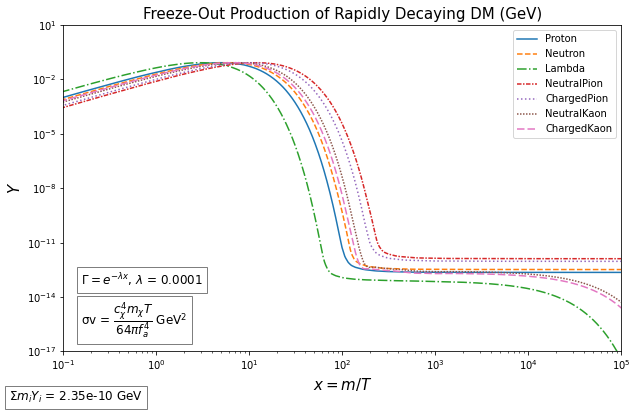

In [12]:
# Integration setup
particles = ["Proton", "Neutron", "Lambda", "NeutralPion", "ChargedPion", "NeutralKaon", "ChargedKaon"]

x_min, x_max = 1e-2, 1e5
x_eval = np.logspace(np.log10(x_min), np.log10(x_max), 10000)

# Plot equilibrium abundance
xx = np.logspace(np.log10(x_min), np.log10(1000), 10000)
#plt.loglog(xx, Y_EQ(xx, 'Proton'), 'c', label=r'$Y_{\rm eq}$, Proton')
plt.figure(figsize=(10, 6))


FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particles:
    mass = particle_mass.get(particle, 1)
    
    sol = integrate.solve_ivp(
        lambda x, logY: dYdx_logdynamic(x, logY, particle),
        (x_min, x_max),
        [np.log(np.array(Y_EQ(x_min, particle)))],  
        method='BDF',  
        t_eval=x_eval,
        rtol=1e-2,
        atol=1e-2,
        jac = None
    )

    # Convert back from log space
    Y_values = np.exp(sol.y[0])
    
    if particle in ("Lambda", "NeutralKaon", "ChargedKaon"):
        Y_values_decay = Y_values*AvgDecayRate(x_eval)
        plt.loglog(sol.t, Y_values_decay, label=f'{particle}',linestyle=linestyles.get(particle, "-"))
        print(particle, np.shape(Y_values_decay))

    else:
        plt.loglog(sol.t, Y_values, label=f'{particle}',linestyle=linestyles.get(particle, "-"))
        print(particle, np.shape(Y_values))

    FreezeOutNumber = np.append(FreezeOutNumber, Y_values[-1])
    masses = np.append(masses, mass)

#print('masses = ', masses)
#print('fz', FreezeOutNumber)
#print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')

plt.gcf().text(0.15, 0.15, r"σv = $\dfrac{c_{χ}^{4} m_χT}{64πf_a^4} $ GeV$^{2}$", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
plt.gcf().text(0.15, 0.27, rf"$\Gamma = e^{{-\lambda x}}$, $\lambda$ = {DecayConstant}", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
plt.gcf().text(0.05, 0.001, rf"$\Sigma m_{{i}}Y_{{i}}$ = {format(np.sum(np.multiply(masses, FreezeOutNumber)), '.2e')} GeV", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))

plt.ylim(1E-17,10)
plt.xlim(0.1,x_max)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-Out Production of Rapidly Decaying DM (GeV)', size= 15)
plt.legend()
#plt.savefig('RapidlyDecayingFreezeOut.png', facecolor = 'w')

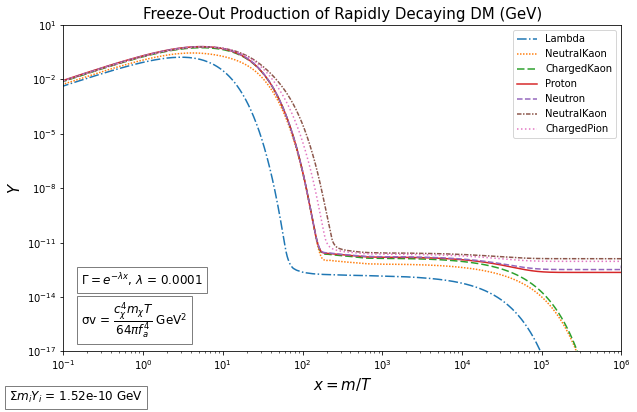

In [13]:
# Integration setup
particles = ["Proton", "Neutron", "NeutralPion", "ChargedPion","Lambda", "NeutralKaon", "ChargedKaon"]

x_min, x_max = 1e-2, 1e6
x_eval = np.logspace(np.log10(x_min), np.log10(x_max), 10000)

# Plot equilibrium abundance
xx = np.logspace(np.log10(x_min), np.log10(1000), 10000)
#plt.loglog(xx, Y_EQ(xx, 'Proton'), 'c', label=r'$Y_{\rm eq}$, Proton')
plt.figure(figsize=(10, 6))


FreezeOutNumber = np.zeros((len(particles), len(x_eval)))
Y_values_array = []
masses = np.array([])

for particle in particles:
    mass = particle_mass.get(particle, 1)
    
    sol = integrate.solve_ivp(
        lambda x, logY: dYdx_logdynamic(x, logY, particle),
        (x_min, x_max),
        [np.log(np.array(Y_EQ(x_min, particle)))],  
        method='BDF',  
        t_eval=x_eval,
        rtol=1e-2,
        atol=1e-2,
        jac = None
    )

    # Convert back from log space
    Y_values = np.exp(sol.y[0])
    
    if particle in decay_products:
        Y_values_decay = Y_values * AvgDecayRate(x_eval)
        if np.any(Y_values_decay < 0):
            print("Warning: Decay contribution is negative! Check your decay model.")
        for products in decay_products[particle]:
            for product in products:
                idx = particles.index(product)
                initial_Proton_abundance = FreezeOutNumber[particles.index("Proton")].copy()
                initial_Neutron_abundance = FreezeOutNumber[particles.index("Neutron")].copy()
                initial_NeutralPion_abundance = FreezeOutNumber[particles.index("NeutralPion")].copy()
                initial_ChargedPion_abundance = FreezeOutNumber[particles.index("ChargedPion")].copy()

                FreezeOutNumber[particles.index("Proton")] += 0.5 * Y_values_decay
                FreezeOutNumber[particles.index("Neutron")] += 0.5 * Y_values_decay
                FreezeOutNumber[particles.index("NeutralPion")] += 0.5 * Y_values_decay
                FreezeOutNumber[particles.index("ChargedPion")] += 0.5 * Y_values_decay
                    
        plt.loglog(sol.t, FreezeOutNumber[idx, :], label=f'{particle}',linestyle=linestyles.get(particle, "-"))

    Y_values_array.append(Y_values)
    FreezeOutNumber[1, -1] = Y_values[-1]
    masses = np.append(masses, mass)

    
Total_Proton = FreezeOutNumber[particles.index("Proton")] + Y_values_array[particles.index('Proton')]
Total_Neutron = FreezeOutNumber[particles.index("Neutron")] + Y_values_array[particles.index('Neutron')]
Total_NeutralPion = FreezeOutNumber[particles.index("NeutralPion")] + Y_values_array[particles.index('NeutralPion')]
Total_ChargedPion = FreezeOutNumber[particles.index("ChargedPion")] + Y_values_array[particles.index('ChargedPion')]

plt.loglog(x_eval, Total_Proton, label = 'Proton', linestyle = '-')
plt.loglog(x_eval, Total_Neutron, label = 'Neutron', linestyle = '--')
plt.loglog(x_eval, Total_NeutralPion, label = 'NeutralKaon', linestyle = (0,(3,1,1,1)))
plt.loglog(x_eval, Total_ChargedPion, label = 'ChargedPion', linestyle = ':')

#print('masses = ', masses)
#print('fz', FreezeOutNumber)
#print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')

plt.gcf().text(0.15, 0.15, r"σv = $\dfrac{c_{χ}^{4} m_χT}{64πf_a^4} $ GeV$^{2}$", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
plt.gcf().text(0.15, 0.27, rf"$\Gamma = e^{{-\lambda x}}$, $\lambda$ = {DecayConstant}", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
plt.gcf().text(0.05, 0.001, rf"$\Sigma m_{{i}}Y_{{i}}$ = {format(np.sum(np.multiply(masses, FreezeOutNumber[1,-1])), '.2e')} GeV", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))

plt.ylim(1E-17,10)
plt.xlim(0.1,x_max)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-Out Production of Rapidly Decaying DM (GeV)', size= 15)
plt.legend()
#plt.savefig('CoupledFreezeOut.png', facecolor = 'w')

In [6]:
import matplotlib.pyplot as plt

# Define x-axis (assuming x_eval corresponds to time or temperature ratio)
x_values = x_eval  

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each final abundance
plt.plot(x_values, final_Proton_abundance, label="Proton", linestyle='-', color='b')
plt.plot(x_values, final_Neutron_abundance, label="Neutron", linestyle='--', color='g')
plt.plot(x_values, final_NeutralPion_abundance, label="Neutral Pion", linestyle='-.', color='r')
plt.plot(x_values, final_ChargedPion_abundance, label="Charged Pion", linestyle=':', color='m')

# Set logarithmic scale for better visualization
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel("x (T/M)")
plt.ylabel("Y (Abundance)")
plt.title("Final Abundances of Particles After Decay Contributions")
plt.legend()

# Show the plot
plt.show()


NameError: name 'final_Proton_abundance' is not defined

<Figure size 720x432 with 0 Axes>

In [ ]:
def lightdom(x):
    return x**(-4)

def matterdom(x):
    return x**(-3)

#plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(10, 6))

T_ex = np.linspace(0.1, 3, num = 10000)

Y_lightdom = lightdom(T_ex)
Y_matterdom = matterdom(T_ex)

plt.axvline(1, alpha = 0.5, linewidth = 0.5, color = 'black')
plt.axvline(2.15, alpha = 0.5, linewidth = 0.5, color = 'black')
plt.axhline(1e-1, linewidth = 1, color = 'darkgreen', label = 'Vacuum Energy')
plt.plot(T_ex,Y_lightdom, label = 'Radiation', color = 'darkred',linewidth = 1)
plt.plot(T_ex, Y_matterdom, label = 'Matter', color = 'indigo', linewidth = 1)
plt.legend()
plt.xlabel('Time scale (arb. units)')
plt.ylabel('Relative density  (arb. units)')
plt.yscale('log')
plt.text(1.3,1e3,"Matter dominated universe", bbox=dict(facecolor='white', alpha=0.5), size = 'x-small')
plt.text(0.225,1e3,"Radiation dominated universe", bbox=dict(facecolor='white', alpha=0.5), size = 'x-small')
plt.text(2.3,1e3,"Vacuum Energy dominated universe", bbox=dict(facecolor='white', alpha=0.5), size = 'x-small')

#plt.grid(linestyle = '--')
#plt.ylim(0,3)
#plt.savefig('TimeScaleArb.png')

In [ ]:

"""
%run FreezeOutFunctions.ipynb
#%run CrossSectionFunctions.ipynb

particle_cross_sections = {
    'Proton': 2e-9,
    'Neutron': 3e-9,
    'Lambda': 1e-7,
    'NeutralPion': 4e-9,
    'ChargedPion': 5e-9,
    'NeutralKaon': 5e-9,
    'ChargedKaon': 6e-9,
}

particle_mass = {
    'Proton': 100,
    'NeutralPion': 1,
}

particle_coupling_constants = {
    'NeutralPion': 1e-1,
}

particles = ['Proton']#["Proton", "Neutron", "Lambda", "ChargedPion", "NeutralPion", "ChargedKaon", "NeutralKaon"]

xmax = 1e2

#plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(8, 6))

x=np.logspace(np.log10(0.1),np.log10(xmax),10000)

FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particles:
    #cross_section = particle_cross_sections.get(particle,1)
    mass = particle_mass.get(particle,1)
    
    Y=integrate.odeint(dYdx,Y_EQ(x[0], particle), x, args=(particle,))
    Decay_rate = AvgDecayRate(x)
    Y_New = Y.reshape(1,-1)
    
    if particle in ("Lambda", "NeutralKaon", "ChargedKaon"):
        Y_Decayed = np.multiply(Y_New,Decay_rate)
        Y_Decayed_New = Y_Decayed.reshape(-1,1)
        FreezeOutNumber = np.append(FreezeOutNumber,Y_Decayed_New[-1])
        #print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y_Decayed_New[-1]}')
        plt.loglog(x, Y_Decayed_New, label=f'{particle} σv = {cross_section}, m = {mass} GeV', linestyle=linestyles.get(particle, "-"))
        
    else:
        plt.loglog(x, Y, label=f'{particle}: m = {mass} GeV', linestyle=linestyles.get(particle, "-"))
        FreezeOutNumber = np.append(FreezeOutNumber,Y[-1])

        #print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y[-1]}')
    
    masses = np.append(masses, mass)

#print('Frozen-out values: ', FreezeOutNumber)
#print(f'Particle masses: {masses}')
#print('mult', np.multiply(masses,FreezeOutNumber))
print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')

plt.ylim(1e-10,1e2)
plt.xlim(1e-1,xmax)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-out production of Atomic DM GeV', size= 15)
plt.legend()
plt.grid()
plt.gcf().text(0.02, 0.02, f"Σm_i*Y_i = {format(np.sum(np.multiply(masses, FreezeOutNumber)), '.2e')} GeV", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
#plt.savefig('Particles.png', facecolor = 'w')
"""

In [ ]:
from numpy.polynomial.polynomial import polyfit

T = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5])
C = np.array([1.38, 5, 13.1, 28, 52, 87, 136])

b, m = polyfit(C/T, T**2, 1)

print(m)
plt.scatter(C/T, T**2)
plt.plot(C/T, b + (m* C/T))